# Moodsic — E2E Video to Fusion Demo

Run the PERCEIVE pipeline on a video. It detects a primary face per
frame (if any), predicts valence/arousal from scene and face, fuses
them (uncertainty‑aware), and draws an overlay.

Flow:
- Run Setup and Adapters.
- Optionally skim the Helpers.
- In the Experiment cell, set `VIDEO_PATH` and run.

Outputs:
- Time series plot of fused valence/arousal.
- Sample overlays (first and last processed frames).
- Optional: save a full overlay video.


In [1]:
# Setup: repo path + imports

import os, sys, math, time

from pathlib import Path

repo_root = Path.cwd()

if repo_root.name == 'notebooks':
    repo_root = repo_root.parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import numpy as np

try:
    import cv2
except Exception as e:
    raise RuntimeError(f'OpenCV (cv2) is required: {e}')
import matplotlib.pyplot as plt

from utils.runtime_driver import VideoPerceptionResult, perceive_video
print('Repo root:', repo_root)



Repo root: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO


In [2]:
# Adapters (best‑effort): try both scene and face paths
scene_adapter = None
face_processor = None
face_adapter = None

try:
    from models.scene.clip_vit_scene_adapter import SceneCLIPAdapter
    scene_adapter = SceneCLIPAdapter(
        model_name='openai/clip-vit-base-patch32',
        dropout_rate=0.3,
        device='auto',
        tta=3,
    )
    print('SceneCLIPAdapter: OK')
except Exception as e:
    print(f'SceneCLIPAdapter unavailable (transformers/weights/device): {e}')

try:
    from utils.emonet_single_face_processor import EmoNetSingleFaceProcessor
    face_processor = EmoNetSingleFaceProcessor(min_detection_confidence=0.5, padding_ratio=0.2)
    print('Face processor:', 'available' if getattr(face_processor, 'available', False) else 'unavailable')
except Exception as e:
    print(f'Face processor unavailable (mediapipe missing?): {e}')

try:
    from models.face.emonet_adapter import EmoNetAdapter
    face_adapter = EmoNetAdapter(
        ckpt_dir='models/emonet/pretrained',
        n_classes=8,
        device='auto',
        tta=3,
        calibration_checkpoint=None,
    )
    print('EmoNetAdapter: OK')
except Exception as e:
    print(f'EmoNetAdapter unavailable (torch/weights/device): {e}')


SceneCLIPAdapter: OK


I0000 00:00:1758939597.482422 18053560 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1758939597.497255 18053827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Face processor: available
EmoNetAdapter: OK


## EXPERIMENTATION

Instructions:
- Set `VIDEO_PATH` (absolute or repo‑relative).
- Adjust `SCENE_TTA`/`FACE_TTA`, `TARGET_SAMPLE_FPS`, and toggles as needed.
- Run the cell: `perceive_video(...)` handles frame iteration, overlays, and plots fused V/A.
- Optionally set `SAVE_OVERLAY_VIDEO=True` to save an annotated MP4.

Notes:
- TTA increases runtime roughly linearly; 3–5 is a good start.
- Stabilizer holds updates when fused variance is high; helps reduce jitter.


## Stabilization = False

I0000 00:00:1758939598.035110 18053560 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1758939598.036701 18053864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Video opened: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/data/videos/94.mp4 (1280x720 @ 25.00 fps, frames≈2064)
Processed frames: 83
Average valence: -0.16402059279489253
Average arousal: 0.13762903588742484
Sampling stride: 25 (effective ≈ 1.00 fps)


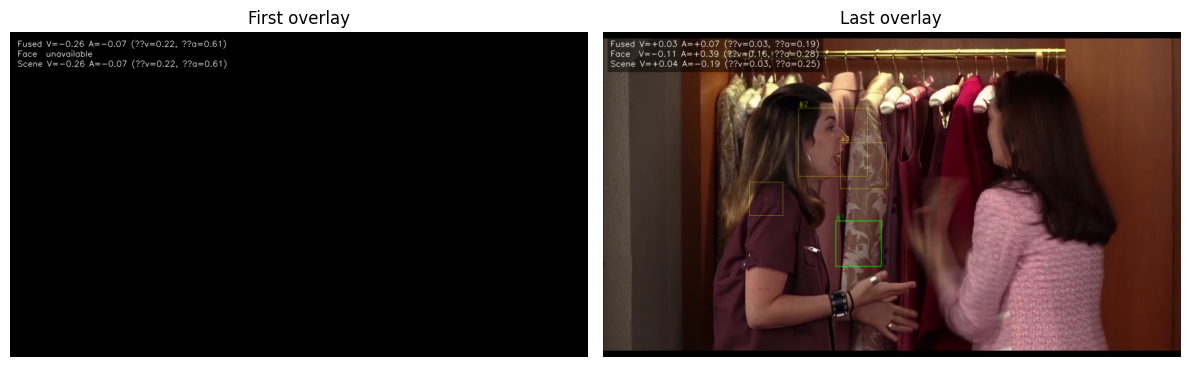

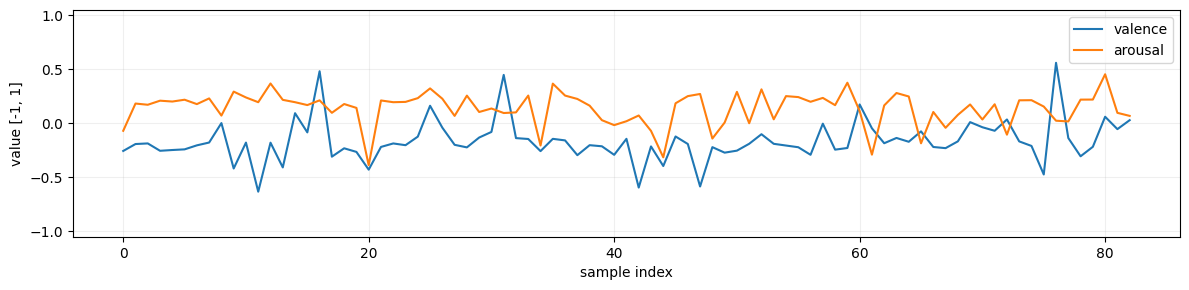

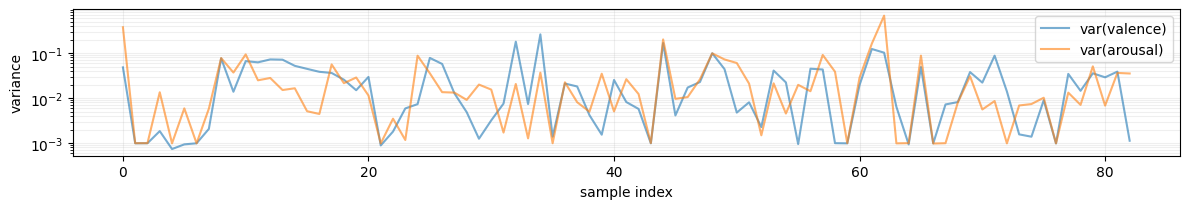

In [3]:
# Experiment: set the video and run

VIDEO_PATH = 'data/videos/94.mp4'  # set to your video

# Runtime/config
SCENE_TTA = 3
FACE_TTA = 3
USE_VARIANCE_WEIGHTING = True
ENABLE_STABILIZER = False
UNCERTAINTY_THRESHOLD = 0.4
STABILIZER_WINDOW = 60
TARGET_SAMPLE_FPS = 1.0      # desired processed frames per second
MAX_FRAMES = None           # e.g., 600 to cap processing

# Overlay video output (optional)
SAVE_OVERLAY_VIDEO = False
OVERLAY_OUT = 'outputs/overlay_fusion.mp4'

src = Path(VIDEO_PATH)
if not src.exists():
    alt = repo_root / VIDEO_PATH
    if alt.exists():
        src = alt

result = perceive_video(
    src,
    scene_predictor=scene_adapter,
    face_processor=face_processor,
    face_expert=face_adapter,
    scene_tta=SCENE_TTA,
    face_tta=FACE_TTA,
    target_sample_fps=TARGET_SAMPLE_FPS,
    max_frames=MAX_FRAMES,
    use_variance_weighting=USE_VARIANCE_WEIGHTING,
    enable_stabilizer=ENABLE_STABILIZER,
    uncertainty_threshold=UNCERTAINTY_THRESHOLD,
    stabilizer_window=STABILIZER_WINDOW,
    save_overlay_to=OVERLAY_OUT if SAVE_OVERLAY_VIDEO else None,
)

frame_total = result.frame_count if result.frame_count is not None else 'unknown'
print(
    f"Video opened: {result.video_path} ({result.width}x{result.height} @ {result.fps:.2f} fps, frames≈{frame_total})"
)
print(f'Processed frames: {result.processed_frames}')
print(f'Average valence: {result.average_valence}')
print(f'Average arousal: {result.average_arousal}')
print(f'Sampling stride: {result.sample_stride} (effective ≈ {result.effective_fps:.2f} fps)')
if result.overlay_path:
    print(f'Overlay video saved to: {result.overlay_path}')

first_overlay, last_overlay = result.first_overlay, result.last_overlay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
if first_overlay is not None:
    axes[0].imshow(cv2.cvtColor(first_overlay, cv2.COLOR_BGR2RGB))
    axes[0].set_title('First overlay')
    axes[0].axis('off')
if last_overlay is not None:
    axes[1].imshow(cv2.cvtColor(last_overlay, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Last overlay')
    axes[1].axis('off')
plt.tight_layout(); plt.show()

if result.valence:
    sample_indices = np.arange(len(result.frame_indices), dtype=int)
    vals = np.array(result.valence, dtype=float)
    aros = np.array(result.arousal, dtype=float)
    vvars = np.array(result.var_valence, dtype=float)
    avars = np.array(result.var_arousal, dtype=float)

    plt.figure(figsize=(12, 3))
    plt.plot(sample_indices, vals, label='valence', color='tab:blue')
    plt.plot(sample_indices, aros, label='arousal', color='tab:orange')
    plt.xlabel('sample index')
    plt.ylabel('value [-1, 1]')
    plt.ylim(-1.05, 1.05)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout(); plt.show()

    if not (np.isnan(vvars).all() and np.isnan(avars).all()):
        plt.figure(figsize=(12, 2.2))
        plt.plot(sample_indices, vvars, label='var(valence)', color='tab:blue', alpha=0.6)
        plt.plot(sample_indices, avars, label='var(arousal)', color='tab:orange', alpha=0.6)
        plt.xlabel('sample index')
        plt.ylabel('variance')
        plt.yscale('log')
        plt.grid(True, which='both', alpha=0.2)
        plt.legend(); plt.tight_layout(); plt.show()
else:
    print('No frames processed; check VIDEO_PATH or adapters availability.')


## Stabilization = True

Video opened: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/data/videos/94.mp4 (1280x720 @ 25.00 fps, frames≈2064)
Processed frames: 83
Average valence: -0.15166289224223806
Average arousal: 0.12870950253307112
Sampling stride: 25 (effective ≈ 1.00 fps)


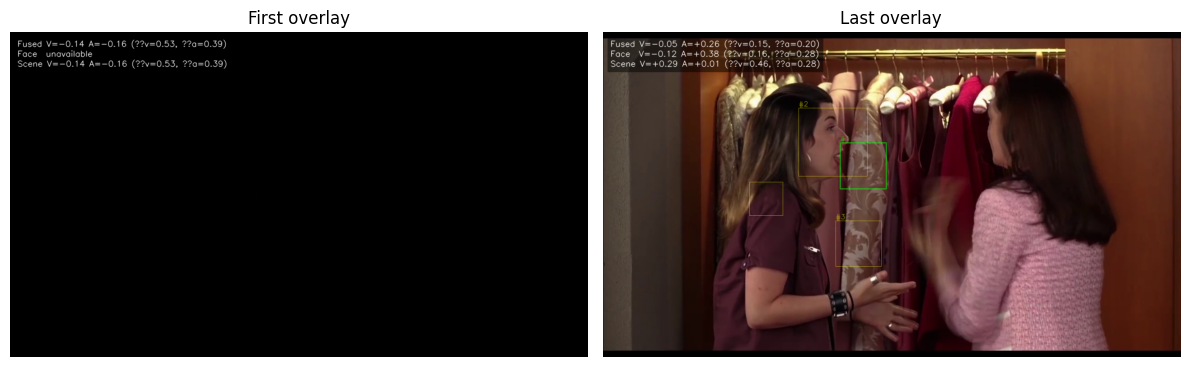

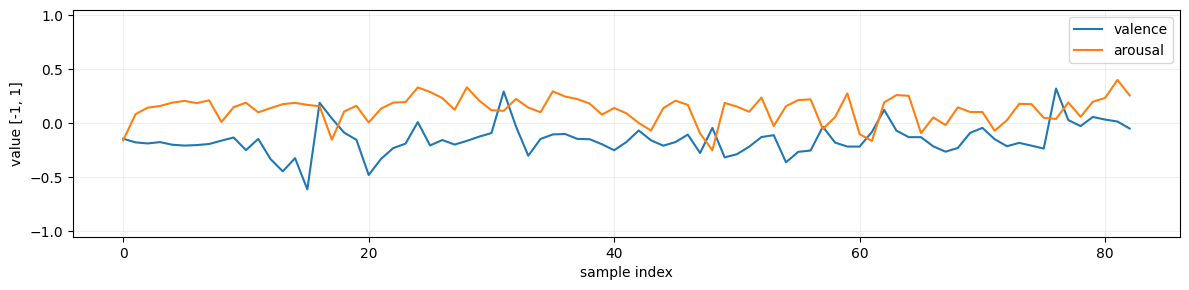

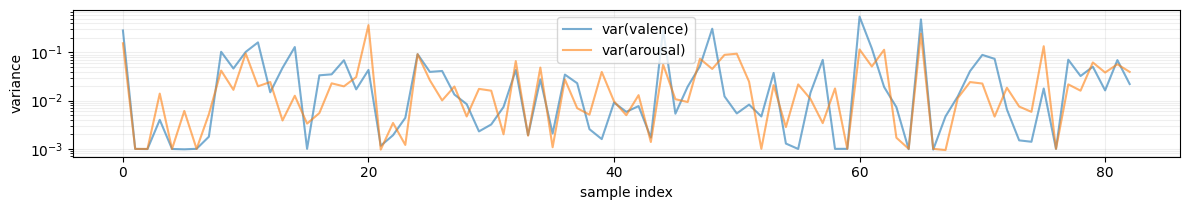

In [4]:
# Experiment: set the video and run

VIDEO_PATH = 'data/videos/94.mp4'  # set to your video

# Runtime/config
SCENE_TTA = 3
FACE_TTA = 3
USE_VARIANCE_WEIGHTING = True
ENABLE_STABILIZER = True
UNCERTAINTY_THRESHOLD = 0.4
STABILIZER_WINDOW = 60
TARGET_SAMPLE_FPS = 1.0      # desired processed frames per second
MAX_FRAMES = None           # e.g., 600 to cap processing

# Overlay video output (optional)
SAVE_OVERLAY_VIDEO = False
OVERLAY_OUT = 'outputs/overlay_fusion.mp4'

src = Path(VIDEO_PATH)
if not src.exists():
    alt = repo_root / VIDEO_PATH
    if alt.exists():
        src = alt

result = perceive_video(
    src,
    scene_predictor=scene_adapter,
    face_processor=face_processor,
    face_expert=face_adapter,
    scene_tta=SCENE_TTA,
    face_tta=FACE_TTA,
    target_sample_fps=TARGET_SAMPLE_FPS,
    max_frames=MAX_FRAMES,
    use_variance_weighting=USE_VARIANCE_WEIGHTING,
    enable_stabilizer=ENABLE_STABILIZER,
    uncertainty_threshold=UNCERTAINTY_THRESHOLD,
    stabilizer_window=STABILIZER_WINDOW,
    save_overlay_to=OVERLAY_OUT if SAVE_OVERLAY_VIDEO else None,
)

frame_total = result.frame_count if result.frame_count is not None else 'unknown'
print(
    f"Video opened: {result.video_path} ({result.width}x{result.height} @ {result.fps:.2f} fps, frames≈{frame_total})"
)

print(f'Processed frames: {result.processed_frames}')
print(f'Average valence: {result.average_valence}')
print(f'Average arousal: {result.average_arousal}')
print(f'Sampling stride: {result.sample_stride} (effective ≈ {result.effective_fps:.2f} fps)')
if result.overlay_path:
    print(f'Overlay video saved to: {result.overlay_path}')

first_overlay, last_overlay = result.first_overlay, result.last_overlay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
if first_overlay is not None:
    axes[0].imshow(cv2.cvtColor(first_overlay, cv2.COLOR_BGR2RGB))
    axes[0].set_title('First overlay')
    axes[0].axis('off')
if last_overlay is not None:
    axes[1].imshow(cv2.cvtColor(last_overlay, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Last overlay')
    axes[1].axis('off')
plt.tight_layout(); plt.show()

if result.valence:
    sample_indices = np.arange(len(result.frame_indices), dtype=int)
    vals = np.array(result.valence, dtype=float)
    aros = np.array(result.arousal, dtype=float)
    vvars = np.array(result.var_valence, dtype=float)
    avars = np.array(result.var_arousal, dtype=float)

    plt.figure(figsize=(12, 3))
    plt.plot(sample_indices, vals, label='valence', color='tab:blue')
    plt.plot(sample_indices, aros, label='arousal', color='tab:orange')
    plt.xlabel('sample index')
    plt.ylabel('value [-1, 1]')
    plt.ylim(-1.05, 1.05)
    plt.grid(True, alpha=0.2)
    plt.legend()
    plt.tight_layout(); plt.show()

    if not (np.isnan(vvars).all() and np.isnan(avars).all()):
        plt.figure(figsize=(12, 2.2))
        plt.plot(sample_indices, vvars, label='var(valence)', color='tab:blue', alpha=0.6)
        plt.plot(sample_indices, avars, label='var(arousal)', color='tab:orange', alpha=0.6)
        plt.xlabel('sample index')
        plt.ylabel('variance')
        plt.yscale('log')
        plt.grid(True, which='both', alpha=0.2)
        plt.legend(); plt.tight_layout(); plt.show()
else:
    print('No frames processed; check VIDEO_PATH or adapters availability.')
